# 课时21 SSGAN的代码实现

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'1.13.1'

## 1. 导入MNIST数据集

In [17]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('E:\SoftWare_Installing\Pycharm\Pycharm WorkPlace\GAN生成对抗网络入门与实战\data\MNIST', one_hot=True)

Extracting E:\SoftWare_Installing\Pycharm\Pycharm WorkPlace\GAN生成对抗网络入门与实战\data\MNIST\train-images-idx3-ubyte.gz
Extracting E:\SoftWare_Installing\Pycharm\Pycharm WorkPlace\GAN生成对抗网络入门与实战\data\MNIST\train-labels-idx1-ubyte.gz
Extracting E:\SoftWare_Installing\Pycharm\Pycharm WorkPlace\GAN生成对抗网络入门与实战\data\MNIST\t10k-images-idx3-ubyte.gz
Extracting E:\SoftWare_Installing\Pycharm\Pycharm WorkPlace\GAN生成对抗网络入门与实战\data\MNIST\t10k-labels-idx1-ubyte.gz


## 2. 定义模型搭建需要的各个组件

In [18]:
# 定义huber损失
# huber损失与L2损失更加接近，但是这个损失对异常值更加不敏感，也就是对待异常值更健壮
# huber损失是要添加到生成器的损失上面的，其主要作用是使得我们的生成器生成的图片具有更加多样性
def huber_loss(labels, predictions, delta=1.0):
    residual = tf.abs(predictions-labels)
    condition = tf.less(residual, delta)
    small_res = 0.5*tf.square(residual)
    large_res = delta*residual - 0.5*tf.square(delta)
    return tf.where(condition, small_res, large_res)

In [19]:
# 定义生成器
def generator(noise_img, is_train=True):
    with tf.variable_scope(name_or_scope='generator', reuse=(not is_train)):
        # 第一层为全连接层，将噪声数据的维度从100 x 1 ===> 4 x 4 x 512
        layer_1 = tf.layers.dense(noise_img, 4*4*512)
        layer_1 = tf.reshape(layer_1, [-1, 4, 4, 512])
        # batch_normalization
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.nn.relu(layer_1)
        # dropout
        layer_1 = tf.nn.dropout(layer_1, keep_prob=0.8)
        
        # 4 x 4 x 512 ===> 7 x 7 x 256
        layer_2 = tf.layers.conv2d_transpose(inputs=layer_1, filters=256, 
                                             kernel_size=4,
                                             strides=1, padding='valid')
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.nn.relu(layer_2)
        layer_2 = tf.nn.dropout(layer_2, keep_prob=0.8)
        
        # 7 x 7 x 256 ===> 14 x 14 x 128
        layer_3 = tf.layers.conv2d_transpose(inputs=layer_2, filters=128, 
                                             kernel_size=3,
                                             strides=2, padding='same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.nn.relu(layer_3)
        layer_3 = tf.nn.dropout(layer_3, keep_prob=0.8)
        
        # 14 x 14 x 128 ===> 28 x 28 x 1
        logits = tf.layers.conv2d_transpose(inputs=layer_3, filters=1,
                                            kernel_size=3,
                                            strides=2, padding='same')
        outputs = tf.tanh(logits)
        return outputs

In [20]:
# 定义判别器
def discriminator(inputs_img, reuse=False, alpha=0.2):
    with tf.variable_scope(name_or_scope='discriminator', reuse=reuse):
        # [28, 28, 1] ===> [14, 14, 128]
        # 第一层不加BN
        layer_1 = tf.layers.conv2d(inputs=inputs_img, filters=128, kernel_size=3,
                                   strides=2, padding='same')
        layer_1 = tf.maximum(alpha*layer_1, layer_1)
        layer_1 = tf.nn.dropout(layer_1, keep_prob=0.8)
        
        # [14, 14, 128] ===> [7, 7, 256]
        layer_2 = tf.layers.conv2d(inputs=layer_1, filters=256, kernel_size=3,
                                   strides=2, padding='same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha*layer_2, layer_2)
        layer_2 = tf.nn.dropout(layer_2, keep_prob=0.8)
        
        # [7, 7, 256] ===> [4, 4, 512]
        layer_3 = tf.layers.conv2d(inputs=layer_2, filters=512, kernel_size=3,
                                   strides=2, padding='same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha*layer_3, layer_3)
        layer_3 = tf.nn.dropout(layer_3, keep_prob=0.8)
        
        # [4, 4, 512] ===> [4*4*512, 1]
        flatten = tf.reshape(layer_3, (-1, 4*4*512))
        # SSGAN中最后输出的是一个有着11类的类别向量
        logits = tf.layers.dense(flatten, 11)
        outputs = tf.nn.softmax(logits)
        
        return logits, outputs

In [21]:
# 获取loss值
def get_loss(inputs_real, inputs_noise, input_label_real, input_label_fake, smooth=0.1):
    g_outputs = generator(inputs_noise, is_train=True)
    d_logits_real, d_output_real = discriminator(inputs_real)
    d_logits_fake, d_output_fake = discriminator(g_outputs, reuse=True)
    
    # 计算generator_loss值
    # 由于我们希望g_loss尽可能小，也就是希望判别器对于生成器生成的数据g_outputs传入
    # 到判别器之后得出的类别判断结果d_output_fake尽可能的出现在11个类别中的前面10个中，
    # 因为前面判别器的结果出现在前面10个中的某一个的时候说明判别器将这个样本判别为了真实数据
    # 因此对于生成器来说，它希望尽可能的欺骗到判别器，也就说它希望自己产生的样本送到判别器后
    # 判别器将其判别为第11类d_output_fake[:, -1]的可能性tf.log(d_output_fake[:, -1])尽可能为0，
    # 这样的话，生成器的损失tf.reduce_mean(tf.log(d_output_fake[:, -1]))就会尽可能的小了
    g_loss = tf.reduce_mean(tf.log(d_output_fake[:, -1]))
    # 增加huber_loss，增加生成样本的多样性，其中0.0001为系数，目的是希望huber_loss的影响不要太大
    # 如果系数太大则代表是希望生成的图像和真实的图像尽可能一样，但是这不是我们想要看到的，我们希望的是有多样性
    g_loss += tf.reduce_mean(huber_loss(inputs_real, g_outputs))*0.0001
    
    # 计算discrimidiscriminator_loss值
    d_loss_real = tf.nn.softmax_cross_entropy_with_logits_v2(logits=d_logits_real, labels=input_label_real)
    d_loss_fake = tf.nn.softmax_cross_entropy_with_logits_v2(logits=d_logits_fake, labels=input_label_fake)
    d_loss = tf.reduce_mean(d_loss_real + d_loss_fake)
    
    return g_loss, d_loss

In [22]:
# 设置优化器
def get_optimizer(g_loss, d_loss, beta1=0.4, learning_rate=0.001):
    train_vars = tf.trainable_variables()
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    # optimizers
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        # 这里加快了generator的学习速率
        g_opt = tf.train.AdamOptimizer(learning_rate*5, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return g_opt, d_opt

In [23]:
# 单独创建一个绘图函数用于后面绘制每一步生成器产生的图像
def plot_image(samples):
    # 由于生成器采用的激活函数是[-1, 1]之间，为了能够更好的绘图
    # 需要将其转换到[0, 1]之间，因此有下面一行的操作
    samples = (samples + 1) / 2
    fig, axes = plt.subplots(nrows=1, ncols=25, sharex=True, 
                             sharey=True, figsize=(50, 2))
    for img, ax in zip(samples, axes):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0)

In [24]:
# 展示生成器的生成结果
def show_generator_output(sess, noise_image):
    samples = sess.run(generator(noise_image, False))
    return samples

In [25]:
# 定义参数
batch_sizes = 64
noise_size = 100
epochs = 50
n_samples = 25
learning_rate = 0.001
beta1 = 0.6

In [26]:
def train(noise_size, batch_size, n_samples):
    # 存储loss
    losses = []
    step = 0
    
    inputs_real = tf.placeholder(tf.float32, [None, 28, 28, 1], name='inputs_real')
    inputs_noise = tf.placeholder(tf.float32, [None, noise_size], name='inputs_noise')
    inputs_label_real = tf.placeholder(tf.float32, [None, 11], name='inputs_label_real')
    inputs_label_fake = tf.placeholder(tf.float32, [None, 11], name='inputs_label_real')
    
    g_loss, d_loss = get_loss(inputs_real, inputs_noise, inputs_label_real, inputs_label_fake)
    g_train_opt, d_train_opt = get_optimizer(g_loss, d_loss, beta1, learning_rate)
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            for batch_i in range(mnist.train.num_examples // batch_size):
                step += 1
                batch_images_, batch_labels = mnist.train.next_batch(batch_size)
                batch_images = batch_images_.reshape((batch_size, 28, 28, 1))
                # [-1, 1]
                batch_images = batch_images*2 - 1
                
                alpha = 0.9
                
                real_label = sess.run(tf.concat([batch_labels, 
                                                 tf.zeros([batch_size, 1])], axis=1))
                fake_label = sess.run(tf.concat([(1-alpha)*tf.ones([batch_size, 10])/10,
                                                 alpha*tf.ones([batch_size, 1])], axis=1))
                
                # noise
                batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
                
                # Run optimizers
                _ = sess.run(g_train_opt, feed_dict={inputs_real:batch_images,
                                                     inputs_noise:batch_noise,
                                                     inputs_label_real: real_label,
                                                     inputs_label_fake: fake_label})
                _ = sess.run(d_train_opt, feed_dict={inputs_real:batch_images,
                                                     inputs_noise:batch_noise,
                                                     inputs_label_real: real_label,
                                                     inputs_label_fake: fake_label})
                
                
                if step % 5 == 0:
                    train_loss_d = d_loss.eval({inputs_real:batch_images,
                                                inputs_noise:batch_noise,
                                                inputs_label_real: real_label,
                                                inputs_label_fake: fake_label})
                    train_loss_g = g_loss.eval({inputs_real:batch_images,
                                                inputs_noise:batch_noise,
                                                inputs_label_real: real_label,
                                                inputs_label_fake: fake_label})
                    losses.append((train_loss_d, train_loss_g))
                    
                    # 显示图片
                    batch_noise = np.random.uniform(-1, 1, size=(10, noise_size))
                    batch_noise = tf.cast(batch_noise, tf.float32)
                    samples = show_generator_output(sess, batch_noise)
                    plot_image(samples)
                    
                    print('Epoch is %i/%i'%(epoch+1, epochs),
                          'Discriminator Loss is %.3f'%(train_loss_d),
                          ', Generator Loss is %.3f'%(train_loss_g))
        saver.save(sess, '../tf_saver_files/class_9_of_SSGAN/generator.ckpt')

Instructions for updating:
Use keras.layers.conv2d instead.
Epoch is 1/50 Discriminator Loss is 1.646 , Generator Loss is -0.371


KeyboardInterrupt: 

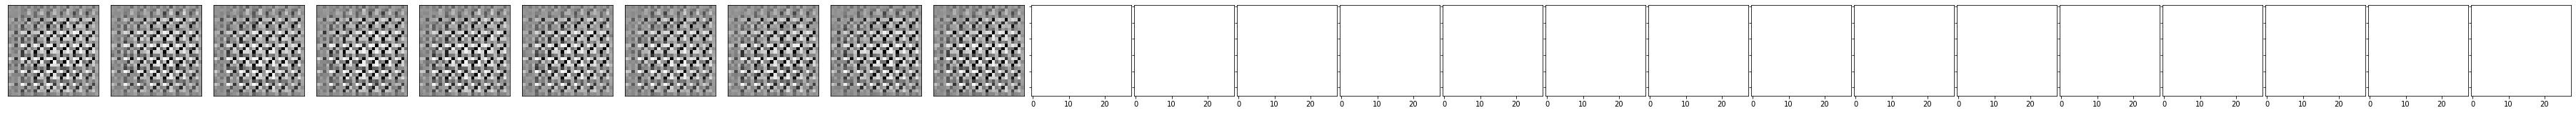

In [27]:
with tf.Graph().as_default():
    train(noise_size, batch_sizes, n_samples)